In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py
import my_functions as mf
speed_of_light = 299792.458
path = '../Data/011/Lev6/' #path for the simulation
extrapolation_order = 2

alm = []
H2 = []

input_file1 = h5py.File(path+'rhOverM_Asymptotic_GeometricUnits.h5','r')
SXS = input_file1['Extrapolated_N%i.dir'%(extrapolation_order)]['Y_l%i_m%i.dat'%(2,-1)]
t = SXS[:,0]
dt = np.diff(t)

def ALM(l,m):
    #print("lol",l,m)
    if m>l or m<-l or l<2 or l>8:
        return 0
    return alm[l-2][m+l]
def Hcomp(l,m):
    if m>l or m<-l or l<2 or l>8:
        return 0
    return H2[l-2][m+l]
def norm(vector):
    return np.sqrt(vector[0]*vector[0]+vector[1]*vector[1]+vector[2]*vector[2])

meta = open(path+'metadata.txt','r')
for line in meta:
    line = line.translate(None,",")
    line = line.split()
    if(len(line)<2):
        continue;
    var = line[0].translate(None," ")
    if var == 'initial-ADM-energy':
        initial_mass = float(line[2])
    if var == 'initial-ADM-linear-momentum':
        initial_p = np.array([float(line[2]),float(line[3]),float(line[4])])
    if var == 'initial-ADM-angular-momentum':
        initial_j = np.array([float(line[2]),float(line[3]),float(line[4])])
    if var == 'remnant-mass':
        remnant_mass = float(line[2])
    if var == 'remnant-spin':
        remnant_spin = np.array([float(line[2]),float(line[3]),float(line[4])])
    if var == 'initial-mass1':
        initial_mass1 = float(line[2])
    if var == 'initial-mass2':
        initial_mass2 = float(line[2])
    if var == 'initial-spin1':
        initial_spin1 = np.array([float(line[2]),float(line[3]),float(line[4])])
    if var == 'initial-spin2':
        initial_spin2 = np.array([float(line[2]),float(line[3]),float(line[4])])
    
        
#The following are coefficients used in calculations of radiated angular and linear momentum       
def f(l,m):
    return np.sqrt((l-m)*(l+m+1))
def a(l,m):
    return np.sqrt((1.0+0j)*(l-m)*(l+m+1.0))/(l*(l+1.0))
def b(l,m):
    return (np.sqrt((1+0j)*(l-2.0)*(l+2.0)*(l+m)*(l+m-1.0)/(2.0*l-1.0)/(2.0*l+1.0)))/(2.0*l)
def c(l,m):
    return 2.0*m/(l*(l+1.0))
def d(l,m):
    return (np.sqrt((1.0+0j)*(l-2.0)*(l+2.0)*(l-m)*(l+m)/(2.0*l-1.0)/(2.0*l+1)))/l

#Calculates the H and Hdots to be used for further analysis.
for l in range(2,9):
    alm.append([])
    H2.append([])
    for m in range(-l,l+1):
        SXS = input_file1['Extrapolated_N2.dir']['Y_l%i_m%i.dat'%(l,m)]
        H = SXS[:,1]+(0+1j)*SXS[:,2]
        t = SXS[:,0]
        Hdot = np.diff(H)/np.diff(t)
        alm[l-2].append(Hdot)
        H2[l-2].append(H[1:])     
    

    

In [33]:
l_kick = [] #Stores the kick velocities for different l values
for L in range(5,9):    
    dp_plus = (0+0j)*(dt)
    dp_z = dp_plus
    for l in range(2,L+1):
        for m in range(-l,l+1):
            dp_plus = dp_plus+ALM(l,m)*(a(l,m)*np.conj(ALM(l,m+1)) + b(l,-m)*np.conj(ALM(l-1,m+1)) - b(l+1,m+1)*np.conj(ALM(l+1,m+1)))
            dp_z = dp_z + ALM(l,m)*(c(l,m)*np.conj(ALM(l,m)) + d(l,m)*np.conj(ALM(l-1,m)) + d(l+1,m)*np.conj(ALM(l+1,m)))
    p_plus = np.cumsum(dp_plus*dt)/(8*np.pi)
    PZ = np.real(np.cumsum(dp_z*dt)/(16*np.pi))
    PX = np.real(p_plus)
    PY = np.imag(p_plus)
    P = np.array([PX,PY,PZ])
    Total_P = norm(P)
    Radiated_P = np.array([PX[-1],PY[-1],PZ[-1]])
    Total_Radiated_P = norm(Radiated_P)
    Kick = -1 * Radiated_P/remnant_mass * speed_of_light
    Total_Kick = norm(Kick) 
    l_kick.append([L,Total_Kick])
l_kick = np.array(l_kick)

l:5.0 kick:619.697488278 km/s deviation: 0.0624609826272%
l:6.0 kick:619.980043356 km/s deviation: 0.0168938152026%
l:7.0 kick:620.07660482 km/s deviation: 0.00132151541445%
l:8.0 kick:620.084799337 km/s deviation: 0.0%


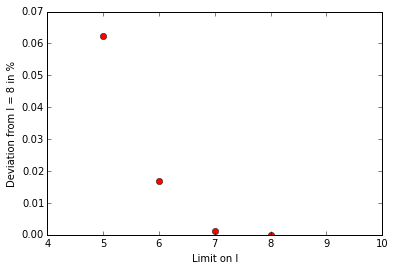

[ 0.06250002  0.01689667  0.00132153  0.        ]
Mass Ratio: 1.5
Initial Spin1: [  9.00000000e-02  -6.68541600e-12   1.55884680e-01]
Initial Spin2: [  7.02889600e-12  -2.18493920e-11   6.23164832e-10]
Final Kick of Blackhole Calculated : [   9.05243651   59.02612647 -617.20266376]
Final Speed of the Blackhole: 620.084799337 km/s


In [34]:
for l in l_kick:
    if(l[0]==8):
        total_kick = l[1]
for l in l_kick:
    print("l:{} kick:{} km/s deviation: {}%".format(l[0],l[1],mf.error(total_kick,l[1]))) 
       
deviation = mf.error(l_kick[:,1],total_kick)
plt.figure(1)
plt.xlabel("Limit on l")
plt.ylabel("Deviation from l = 8 in %")
plt.plot(l_kick[:,0],deviation,'ro')
plt.xlim(4,10)
#plt.ylim(-0.001)
plt.show()

print(deviation)
print("Mass Ratio: {}".format(initial_mass1/initial_mass2))
print("Initial Spin1: {}".format(initial_spin1))
print("Initial Spin2: {}".format(initial_spin2))
print("Final Kick of Blackhole Calculated : {}".format(Kick))
print("Final Speed of the Blackhole: {} km/s".format(Total_Kick))





array([4, 5, 6])